# LSTM Baseline

In [35]:
# Enable autoreload of local Python modules (e.g., models)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import numpy as np
import jax
import jax.numpy as jnp
import optax
import time

# save checkpoints using orbax
from pathlib import Path

# local imports
import models.LSTM as models
import utils.generation as generation
import utils.eval as eval

# utilities
# Import our new utilities
from utils import (
    load_config,
    print_config,
    plot_training_curves,
    analyze_training_performance,
    save_collected_checkpoints,
    logger,
    test_checkpoint,
    load_checkpoint,
)

# Load data

In [37]:
# load the ./data/text8_train.txt and ./data/text8_test.txt files
with open("./data/text8_train.txt", "r") as f:
    train_text_full = f.read()
with open("./data/text8_test.txt", "r") as f:
    test_text = f.read()

train_ratio = 0.95
N = len(train_text_full)
cut = int(N * train_ratio)

train_text = train_text_full[:cut]  # training text
val_text = train_text_full[cut:]  # validation text
# print the length of the training text and test text
print(f"Length of training text: {len(train_text):_} characters")
print(f"Length of validation text: {len(val_text):_} characters")
print(f"Length of test text: {len(test_text):_} characters")

Length of training text: 85_500_000 characters
Length of validation text: 4_500_000 characters
Length of test text: 5_000_000 characters


In [38]:
# Build vocabulary (lowercase + space + a few punctuations)
char_set = list("abcdefghijklmnopqrstuvwxyz ")
char_to_int = {ch:i for i,ch in enumerate(char_set)}
int_to_char = {i:ch for ch,i in char_to_int.items()}


def encode(s):
    """Encode string to array of integers"""
    ids = [char_to_int[c] for c in s]
    return np.array(ids, dtype=np.uint8)  # use np.uint8 to save space

In [39]:
# encode the text
train_text_int = encode(train_text)
val_text_int = encode(val_text)
test_text_int = encode(test_text)

In [40]:
# sanity check: display a few random characters from the training text
T = 128
for _ in range(5):
    # choose random position in text
    N = np.random.randint(low=0, high=len(train_text)-T)
    print(train_text[N:N+T])
    print()

nglican clergy may be married and may marry after ordination chastity and celibacy there is a difference between chastity and ce

cs see the chapter by lowe in moore and robin one nine six four karl popper viewed peirce as one of the greatest philosophers of

 and extensive self promotion to potential patrons current issues in lis children s internet protection act censorship informati

e two zero zero four moody s investors service ranked the state one four th for net tax supported debt per capita as a percentag

ne eight nine two may four one nine eight zero was the leader of yugoslavia between the end of world war ii and his death in one



## Load Conifguration

In [41]:
CONFIG_PATH = "./configs/baseline.yaml"
# Load configuration
config = load_config(CONFIG_PATH)
print_config(config)

# Initialize random seed
key = jax.random.key(config.training.seed)


CONFIGURATION
model_name: L-beta
model:
  vocab_size: 27
  hidden_size: 256
  n_layers: 4
  max_len: 128
  dropout: 0.1
loss:
  LABEL_SMOOTHING: True
  ls_eps: 0.05
  entropy_lambda: 0.0
training:
  batch_size: 128
  sequence_length: 128
  learning_rate: 0.0003
  epochs: 1000
  eval_interval: 500
  warmup_iters: 0
  stage_checkpoint_interval: 10000
  seed: 4212
output:
  checkpoint_dir: ./checkpoints
  results_dir: ./runs



## Create a basic LSTM model

In [42]:
def create_train_state(rng, config):
    # create a basic Transformer model
    model = models.CharLSTM(
        vocab_size=config.model.vocab_size,
        hidden_size=config.model.hidden_size,
        n_layers=config.model.n_layers,
        dropout=config.model.dropout,
        max_len=config.model.max_len,
    )

    # create a dummy input for initialization
    dummy = jnp.zeros((1, min(16, config.model.max_len)), dtype=jnp.int32)
    # pass the dummy input to the model to initialize the parameters
    params = model.init({"params": rng}, dummy, train=True)["params"]
    return model, params


def count_params(params):
    return sum(x.size for x in jax.tree_util.tree_leaves(params))

In [44]:
model, params = create_train_state(key, config)
num_params = count_params(params)
print(f"Model created: {config.model_name}")
print(f"Number of parameters: {num_params:_}")

Model created: L-beta
Number of parameters: 2_115_072


In [45]:
# sanity check: create a batch of data & run a forward pass
B, T = 4, 32
batch = jax.random.randint(
    key=key,
    shape=(B, T), minval=0, maxval=len(char_set))
logits = model.apply({"params": params}, batch, train=False)

print("batch shape:", batch.shape)  # (B, T)
print("logits shape:", logits.shape)  # (B, T, vocab_size)

batch shape: (4, 32)
logits shape: (4, 32, 27)


## Loss function

In [46]:
@jax.jit
def loss_and_metrics(logits, targets):

    B, T, V = logits.shape

    # position weights mode
    # linear: w(t) = 0.3 + 0.7 * (t / T)
    # sqrt: w(t) = 0.1 + 0.9 * sqrt(t / T)
    # none: w(t) = 1.0
    tail_scheme = "linear"

    if config.loss.LABEL_SMOOTHING and config.loss.ls_eps > 0.0:
        tgt = jax.nn.one_hot(targets, V)
        tgt = (1.0 - config.loss.ls_eps) * tgt + (config.loss.ls_eps / V)
        per_pos_ce = optax.softmax_cross_entropy(logits, tgt)
    else:
        per_pos_ce = optax.softmax_cross_entropy_with_integer_labels(
            logits.reshape(-1, V), targets.reshape(-1)
        ).reshape(B, T)

    # Position weights: emphasize later positions, but don't discard early ones
    if tail_scheme == "linear":
        w = jnp.linspace(0.3, 1.0, T)
    elif tail_scheme == "sqrt":
        w = 0.1 + 0.9 * jnp.sqrt(jnp.linspace(0.0, 1.0, T))
    else:
        w = jnp.ones((T,))
    w = w[None, :]

    # Weighted loss
    loss_weighted = (per_pos_ce * w).sum() / (B * w.sum())

    # Entropy bonus to encourage less-peaked distributions
    if config.loss.entropy_lambda > 0.0:
        logp = jax.nn.log_softmax(logits, axis=-1)
        p = jnp.exp(logp)
        entropy = -(p * logp).sum(-1).mean()
        train_loss = loss_weighted - config.loss.entropy_lambda * entropy
    else:
        train_loss = loss_weighted

    # Metrics for curve comparison (do not involved in backprop)
    # Mean CE over all positions (unweighted, for alignment with literature/old results)
    loss_all = eval.loss_all(logits, targets)
    loss_last = eval.cross_entropy_last_token_only(logits, targets)
    acc_all, acc_last = eval.accuracy(logits, targets)
    perplexity, avg_loss = eval.perplexity(logits, targets)
    bpc = eval.bits_per_character(avg_loss)
    avg_entropy, entropy_by_position = eval.prediction_entropy(logits)

    # ECE
    ece, calibration_data = eval.expected_calibration_error(logits, targets)

    metrics = {
        "loss_train": train_loss,
        "loss_all": loss_all,
        "loss_last": loss_last,
        "acc": acc_all,
        "acc_last": acc_last,
        "perplexity": perplexity,
        "bpc": bpc,
        "pred_entropy": avg_entropy,
        "ece": [ece, calibration_data],
    }

    return train_loss, metrics

## Optimization step

In [47]:
# create an update function
def train_step(params, step_rng, opt_state, x, y, tx):
    """Single optimization step using optax optimizer.

    Args:
      params: pytree of model parameters.
      opt_state: optax optimizer state corresponding to `params`.
      x: (B, T) int array input tokens.
      y: (B, T) int array target tokens.
      tx: optax.GradientTransformation (already initialized).

    Returns:
      new_params: updated parameters after one gradient step.
      new_opt_state: updated optimizer state.
      metrics: dict of scalar metrics (loss, acc).
    """

    def loss_fn(params):
        logits = model.apply({"params": params}, x, train=True, rngs={"dropout": step_rng})
        loss, metrics = loss_and_metrics(logits, y)
        return loss, metrics

    # compute gradients (loss is scalar, metrics is auxiliary)
    (loss, metrics), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)

    # optax update: compute parameter updates and new optimizer state
    updates, new_opt_state = tx.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state, metrics


# jit: last argument should be static because it is an object
train_step = jax.jit(train_step, static_argnames=("tx",))

## Batch creation

In [48]:
# create a batch from the training data
def get_batch(text_int, B, T):
    """Create a random batch of data from text_int.

    Args:
      text_int: 1D array of token ids.
      B: batch size (number of sequences).
      T: sequence length (number of tokens per sequence).

    Returns:
      x: (B, T) int array input tokens.
      y: (B, T) int array target tokens.
    """
    # choose random starting indices for each sequence in the batch
    ix = np.random.randint(0, len(text_int) - T, size=B)
    # inputs are text from i to i+T
    x = np.stack([text_int[i:i+T] for i in ix])
    # targets are text from i+1 to i+T+1
    y = np.stack([text_int[i+1:i+T+1] for i in ix])
    return jnp.array(x, dtype=jnp.int32), jnp.array(y, dtype=jnp.int32)

## Optimizer creation

In [49]:
# learning rate scheduler
lr_schedule = optax.warmup_cosine_decay_schedule(
    init_value=0.0,
    peak_value=config.training.learning_rate,
    warmup_steps=config.training.warmup_iters,
    decay_steps=max(1, config.training.epochs - config.training.warmup_iters),
    end_value=0.0,
)

# Create AdamW optimizer (Optax)
tx = optax.chain(
    # gradient clipping (optiaonal)
    optax.clip_by_global_norm(1.0),
    optax.adamw(
        learning_rate=lr_schedule,
        b1=0.9,
        b2=0.95,
        eps=1e-8,
        weight_decay=0.1,
    ),
)

# Initialize optimizer state for current params
opt_state = tx.init(params)

print("Optimizer initialized: AdamW with warmup-cosine schedule")

Optimizer initialized: AdamW with warmup-cosine schedule


## Model Training

In [50]:
CKPT_DIR = Path(f"{config.output.checkpoint_dir}/{config.model_name}").resolve()
CKPT_DIR.mkdir(parents=True, exist_ok=True)

STAGE_DIR = CKPT_DIR / 'stage'
BEST_DIR = CKPT_DIR / 'best'
STAGE_DIR.mkdir(exist_ok=True)
BEST_DIR.mkdir(exist_ok=True)

print(f"Checkpoint directory: {CKPT_DIR}")

Checkpoint directory: /home/users/tampbench/jinhang/CharacterLLM/checkpoints/L-beta


In [51]:
metrics_logger = logger.Logger(config.training.epochs)
print(f"Logger initialized: {metrics_logger}")

time_train_history = []
time_val_history = []

checkpoints_to_save = {
    'stage': [],
    'best_loss_all': None,
    'best_acc': None,
    'best_acc_last': None,
    'best_perplexity': None,
}

rng = jax.random.PRNGKey(config.training.seed)

print("Training initialization complete")
print(f"- Number of Epochs: {config.training.epochs:,}")
print(f"- Batch size: {config.training.batch_size}")
print(f"- Eval interval: {config.training.eval_interval}")

Logger initialized: Logger(train_steps=0, eval_steps=0)
Training initialization complete
- Number of Epochs: 1,000
- Batch size: 128
- Eval interval: 500


In [52]:
time_start = time.time()
for it in range(config.training.epochs):
    key, step_key = jax.random.split(key)
    batch = get_batch(train_text_int, config.training.batch_size, config.training.sequence_length)
    input, target = batch[0], batch[1]
    params_new, opt_state_new, metrics = train_step(params, step_key, opt_state, input, target, tx)

    # update params and opt_state
    params = params_new
    opt_state = opt_state_new

    metrics_logger.log_train(metrics)

    time_train_history.append(time.time() - time_start)

    if it % config.training.eval_interval == 0 or it == config.training.epochs - 1:
        time_since_start = time.time() - time_start

        # compute loss on validation set
        B_val, T_val = 1024, 32
        val_batch = get_batch(val_text_int, B_val, T_val)
        val_input, val_target = val_batch[0], val_batch[1]
        val_logits = model.apply({"params": params}, val_input, train=False)

        # validation metrics
        val_weighted_loss, val_metrics = loss_and_metrics(val_logits, val_target)

        # record validation metrics
        metrics_logger.log_eval(it, val_metrics)
        time_val_history.append(time_since_start)

        # print validation metrics
        metrics_logger.print_metrics(time_since_start)

        is_best_loss_all, is_best_acc, is_best_acc_last, is_best_perplexity = metrics_logger.isBest(val_metrics)

        # save checkpoints
        checkpoint_state = {
            'params': params,
            'opt_state': opt_state,
            'rng': rng,
            'step': it,
            'val_loss': float(val_metrics['loss_all']),
            'val_acc': float(val_metrics['acc']),
            'val_acc_last': float(val_metrics['acc_last']),
        }

        if (it + 1) % config.training.stage_checkpoint_interval == 0 or (it + 1) == config.training.epochs:
            checkpoints_to_save['stage'].append((it, checkpoint_state.copy()))
            print(f"\t \t Saved stage checkpoint @ {it:,}")

        if is_best_loss_all:
            checkpoints_to_save['best_loss_all'] = (it, checkpoint_state.copy())
            print(f"\t \t Saving best loss checkpoint at iteration {it}...")

        if is_best_acc:
            checkpoints_to_save['best_acc'] = (it, checkpoint_state.copy())
            print(f"\t \t Saving best accuracy checkpoint at iteration {it}...")

        if is_best_acc_last:
            checkpoints_to_save['best_acc_last'] = (it, checkpoint_state.copy())
            print(f"\t \t Saving best last-character accuracy checkpoint at iteration {it}...")

        if is_best_perplexity:
            checkpoints_to_save['best_perplexity'] = (it, checkpoint_state.copy())
            print(f"\t \t Saving best perplexity checkpoint at iteration {it}...")

total_time = time.time() - time_start


iteration 0  time: 5.0 seconds
	 	 loss (weighted train): 3.2961
	 	 loss (train :: test): 3.2961 :: 3.2944
	 	 loss (last character): 3.2942
	 	 accuracy: 15.8%
	 	 accuracy (last character): 18.2%
	 	 perplexity: 26.9624
	 	 bits-per-character: 4.7529
	 	 ECE: 0.1206
	 	 pred_entropy: 3.2958
	 	 Saving best loss checkpoint at iteration 0...
	 	 Saving best accuracy checkpoint at iteration 0...
	 	 Saving best last-character accuracy checkpoint at iteration 0...
	 	 Saving best perplexity checkpoint at iteration 0...

iteration 500  time: 28.1 seconds
	 	 loss (weighted train): 2.2957
	 	 loss (train :: test): 2.1908 :: 2.1921
	 	 loss (last character): 2.1603
	 	 accuracy: 34.7%
	 	 accuracy (last character): 35.4%
	 	 perplexity: 8.9544
	 	 bits-per-character: 3.1626
	 	 ECE: 0.1206
	 	 pred_entropy: 2.3916
	 	 Saving best loss checkpoint at iteration 500...
	 	 Saving best accuracy checkpoint at iteration 500...
	 	 Saving best last-character accuracy checkpoint at iteration 500..

In [53]:
save_collected_checkpoints(checkpoints_to_save, STAGE_DIR, BEST_DIR)

SAVING CHECKPOINTS
	 Saving stage checkpoint 1 (step 999)...


	 Saved (loss: 2.1211)
	 Saving best loss checkpoint (step 999)...


	 Saved (loss: 2.1211)
	 Saving best accuracy checkpoint (step 999)...


	 Saved (acc: 36.77%)
	 Saving best last-char accuracy checkpoint (step 999)...


	 Saved (acc_last: 38.09%)
	 Saving best perplexity checkpoint (step 999)...
	 Saved (loss: 2.1211)
ALL CHECKPOINTS SAVED


## Performance Analysis

In [54]:
results_dir = Path(f"{config.output.results_dir}/{config.model_name}").resolve()
results_dir.mkdir(parents=True, exist_ok=True)

results = analyze_training_performance(
    metrics_logger=metrics_logger,
    total_time=total_time,
    niter=config.training.epochs,
    n_final=10,
    save_results=True,
    results_path=str(results_dir / 'training_results.json')
)


PERFORMANCE ANALYSIS

Best Test Loss:    2.1211  (at iteration 999)
Best Last Char Loss:    2.0449  (at iteration 999)
Best Test Acc:     36.77%  (at iteration 999)
Best Last Char Acc: 38.09%  (at iteration 999)

Final Average (last 10 checkpoints):
  Test Loss:       2.5359 ± 0.5372
  Last Char Loss:  2.4998 ± 0.5637
  Test Accuracy:   29.08% ± 9.44%
  Last Char Acc:   30.57% ± 8.84%

Training Time:
  Total:           49.8 seconds (0.8 minutes)
  Per Iteration:   0.0498 seconds
  Total Iterations: 1,000

Convergence Analysis:
  Still Improving:    N/A (insufficient data)

✓ Results saved to '/home/users/tampbench/jinhang/CharacterLLM/runs/L-beta/training_results.json'


## Ploting


Figure saved to '/home/users/tampbench/jinhang/CharacterLLM/runs/L-beta/training_curves.pdf'


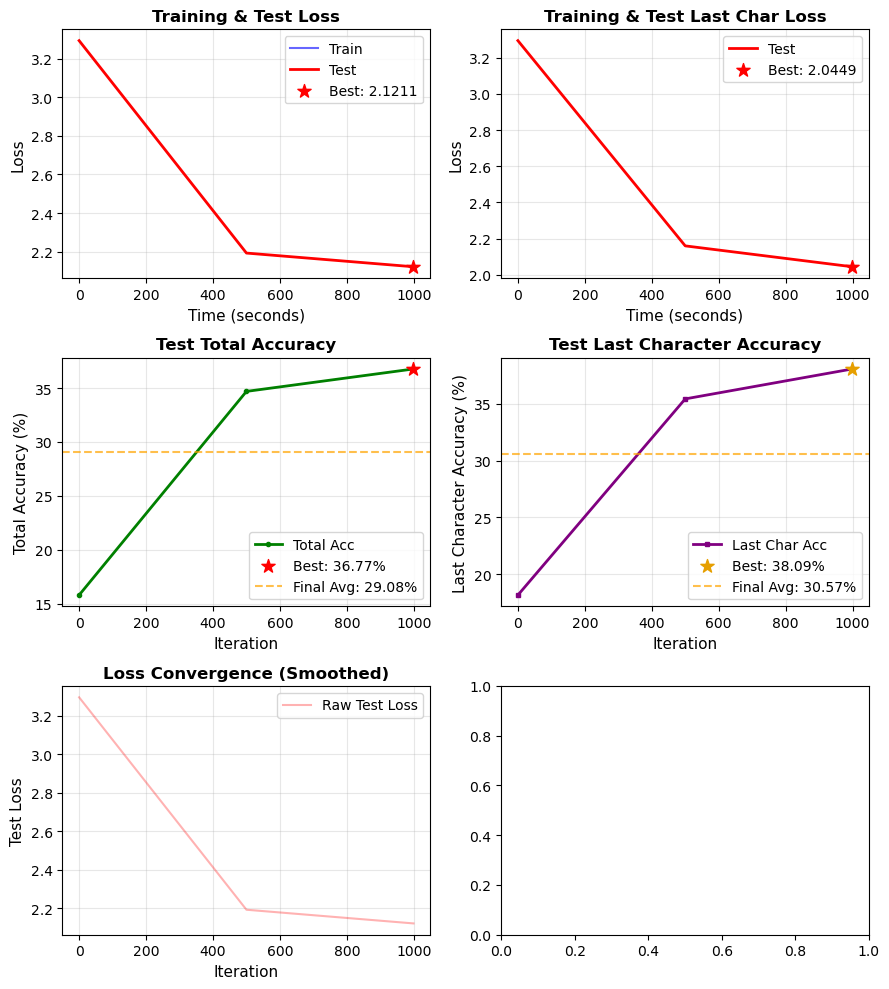

In [55]:
plot_training_curves(
    metrics_logger=metrics_logger,
    save_path=str(results_dir / 'training_curves.pdf')
)

## Evaluation

In [57]:
prompt = "hello my fri"
gen_len = 1000
temperature = 0.7
sample = True
seed = 4212
self_belu_n_grams = 4
self_belu_n_samples = 20

checkpoint_types = [
    ('best_loss_all_', 'Best Loss'),
    ('best_acc_total_', 'Best Accuracy'),
    ('best_acc_last_', 'Best Last-Char Accuracy'),
    ('best_perplexity_', 'Best Perplexity'),
    ('stage_1_', 'Mid Epoch')
]

for prefix, name in checkpoint_types:
    print(f"\n{name}...")
    try:
        # load checkpoint
        checkpoint = load_checkpoint(prefix, name, BEST_DIR, STAGE_DIR)
        params = checkpoint['params']

        # test checkpoint
        test_checkpoint(model, params, test_text_int)
        self_belu_score = eval.self_bleu(
            model, config, int_to_char, char_to_int, char_set, params, prompt, gen_len, temperature, sample, seed,
            n_grams=self_belu_n_grams, n_samples=self_belu_n_samples
            )

        # generate text
        rng = jax.random.PRNGKey(seed)
        prompt_int = jnp.array(
            [[char_to_int.get(c, len(char_set)) for c in prompt.lower()[:config.model.max_len]]],
            dtype=jnp.int32
        )
        out_ids = generation.generate_tokens(
            model, params, rng, prompt_int, gen_len,
            block_size=config.model.max_len,
            temperature=temperature,
            sample=sample
        )
        generated_text = ''.join(int_to_char.get(int(x), '?') for x in list(out_ids[0]))
        full_text = prompt + generated_text

        # save to file
        filename = prefix.replace('_', '') + '.txt'
        output_path = results_dir / filename

        with open(output_path, 'w') as f:
            f.write(f"{name}\n")
            f.write(f"Step: {checkpoint['step']}\n")
            f.write(f"Validation Loss: {checkpoint['val_loss']:.4f}\n")
            f.write(f"Validation Acc: {100*checkpoint['val_acc']:.2f}%\n\n")
            f.write(f"Self-BLEU-{self_belu_n_grams}: {self_belu_score:.4f}\n")
            f.write(full_text)

        print(f"\tSaved to {output_path}")
        print(f"\tPreview: {full_text[:100]}...")

    except Exception as e:
        print(f"\tError: {e}")


Best Loss...
Starting evaluation on test set...
	Error: coherence_score() missing 1 required positional argument: 'int_to_char'

Best Accuracy...
Starting evaluation on test set...
	Error: coherence_score() missing 1 required positional argument: 'int_to_char'

Best Last-Char Accuracy...
Starting evaluation on test set...
	Error: coherence_score() missing 1 required positional argument: 'int_to_char'

Best Perplexity...
Starting evaluation on test set...
	Error: coherence_score() missing 1 required positional argument: 'int_to_char'

Mid Epoch...
Starting evaluation on test set...
	Error: coherence_score() missing 1 required positional argument: 'int_to_char'
